# Continuous-attractor Neural Network

Here we show the implementation of the paper:

- Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. "Dynamics and computation
  of continuous attractors." Neural computation 20.4 (2008): 994-1025.

The mathematical equation of the Continuous-attractor Neural Network (CANN) is given by:

$$\tau \frac{du(x,t)}{dt} = -u(x,t) + \rho \int dx' J(x,x') r(x',t)+I_{ext}$$

$$r(x,t) = \frac{u(x,t)^2}{1 + k \rho \int dx' u(x',t)^2}$$

$$J(x,x') = \frac{1}{\sqrt{2\pi}a}\exp(-\frac{|x-x'|^2}{2a^2})$$

$$I_{ext} = A\exp\left[-\frac{|x-z(t)|^2}{4a^2}\right]$$

In [1]:
import brainpy as bp
import brainpy.numpy as np

bp.profile.set(numerical_method='rk4', dt=0.05)

N = 256  # The number of neurons
tau = 1.  # The synaptic time constant
k = 8.1  # Degree of the rescaled inhibition
a = 0.5  # Half-width of the range of excitatory connections
A = 10.  # Magnitude of the external input
J0 = 4. / (N / 128)
z_min = -np.pi
z_max = np.pi
z_range = z_max - z_min
rho = N / z_range  # The neural density
dx = z_range / N


def dist(d):
    d = np.remainder(d, z_range)
    d = np.where(d > 0.5 * z_range, d - z_range, d)
    return d


# neuron #
# ------ #


@bp.integrate
def int_u(u, t, Jxx, Iext):
    r1 = np.square(u)
    r2 = 1.0 + k * rho * np.sum(r1) * dx
    r = r1 / r2
    Irec = rho * np.dot(Jxx, r) * dx
    dudt = (-u + Irec + Iext) / tau
    return (dudt,), r


def neu_update(ST, _t_, Jxx):
    ST['u'], ST['r'] = int_u(ST['u'], _t_, Jxx, ST['input'])
    ST['input'] = 0.


requires = {
    'ST': bp.types.NeuState(['x', 'u', 'r', 'input']),
    'Jxx': bp.types.Array(dim=2, help='Weight connection matrix.')
}

cann = bp.NeuType(name='CANN',
                  steps=neu_update,
                  requires=requires)


# connection #
# ---------- #


def make_conn(x):
    assert np.ndim(x) == 1
    x_left = np.reshape(x, (len(x), 1))
    x_right = np.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = dist(x_left - x_right)
    jxx = J0 * np.exp(-0.5 * np.square(d / a)) / (np.sqrt(2 * np.pi) * a)
    return jxx

### Population coding

MovieWriter imagemagick unavailable; using Pillow instead.


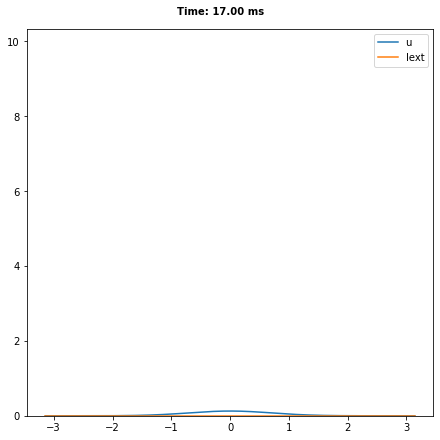

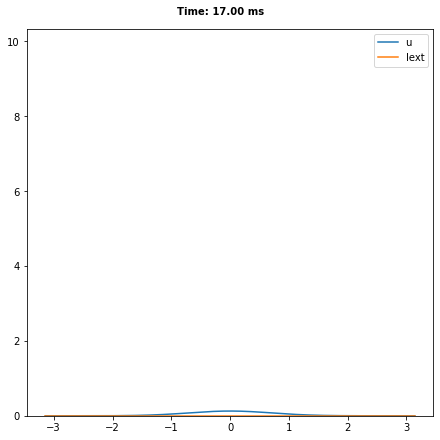

In [2]:
k = 0.1
group = bp.NeuGroup(cann, geometry=N, monitors=['u'])
group.ST['x'] = np.linspace(z_min, z_max, group.num)
group.Jxx = make_conn(group.ST['x'])

I1 = A * np.exp(-0.25 * np.square(dist(group.ST['x'] - 0.) / a))
Iext, duration = bp.inputs.constant_current([(0., 1.), (I1, 8.), (0., 8.)])
group.run(duration=duration, inputs=('ST.input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': group.mon.u, 'xs': group.ST['x'], 'legend': 'u'},
                    {'ys': Iext, 'xs': group.ST['x'], 'legend': 'Iext'}],
    show=False,
    frame_step=1,
    frame_delay=100,
    save_path='../../images/CANN-encoding.gif'
)

<img src="../../images/CANN-encoding.gif">

### Template matching

The CANN can perform efficient population decoding by achieving template-matching. 

In [ ]:
k = 8.1

group = bp.NeuGroup(cann, geometry=N, monitors=['u'])
group.ST['x'] = np.linspace(z_min, z_max, group.num)
group.Jxx = make_conn(group.ST['x'])

dur1, dur2, dur3 = 10., 30., 0.
num1 = int(dur1 / bp.profile.get_dt())
num2 = int(dur2 / bp.profile.get_dt())
num3 = int(dur3 / bp.profile.get_dt())
Iext = np.zeros((num1 + num2 + num3, group.num))
Iext[:num1] = A * np.exp(-0.25 * np.square(dist(group.ST['x'] + 0.5) / a))
Iext[num1:num1 + num2] = A * np.exp(-0.25 * np.square(dist(group.ST['x'] - 0.) / a))
Iext[num1:num1 + num2] += 0.1 * A * np.random.randn(num2, group.num)
group.run(duration=dur1 + dur2 + dur3, inputs=('ST.input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': group.mon.u, 'xs': group.ST['x'], 'legend': 'u'},
                    {'ys': Iext, 'xs': group.ST['x'], 'legend': 'Iext'}],
    show=False,
    frame_step=5,
    frame_delay=50,
    save_path='../../images/CANN-decoding.gif'
)

MovieWriter imagemagick unavailable; using Pillow instead.


<img src="../../images/CANN-decoding.gif">

### Smooth tracking

The CANN can track moving stimulus. 

In [ ]:
group = bp.NeuGroup(cann, geometry=N, monitors=['u'])
group.ST['x'] = np.linspace(z_min, z_max, group.num)
group.Jxx = make_conn(group.ST['x'])

dur1, dur2, dur3 = 20., 20., 20.
num1 = int(dur1 / bp.profile.get_dt())
num2 = int(dur2 / bp.profile.get_dt())
num3 = int(dur3 / bp.profile.get_dt())
position = np.zeros(num1 + num2 + num3)
position[num1: num1 + num2] = np.linspace(0., 12., num2)
position[num1 + num2:] = 12.
position = position.reshape((-1, 1))
Iext = A * np.exp(-0.25 * np.square(dist(group.ST['x'] - position) / a))
group.run(duration=dur1 + dur2 + dur3, inputs=('ST.input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': group.mon.u, 'xs': group.ST['x'], 'legend': 'u'},
                    {'ys': Iext, 'xs': group.ST['x'], 'legend': 'Iext'}],
    show=False,
    frame_step=5,
    frame_delay=50,
    save_path='../../images/CANN-tracking.gif'
)

<img src="../../images/CANN-tracking.gif">